## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

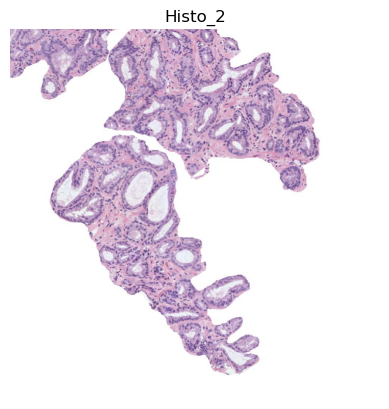

In [1]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen
from skimage import io, img_as_float
import matplotlib.pyplot as plt

# Cargar imágenes y normalizar entre 0 y 1
image_rgb = img_as_float(io.imread("histo_2.jpg"))

# Visualizar imágenes
plt.imshow(image_rgb)
plt.title("Histo_2")
plt.axis("off")
plt.show()


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

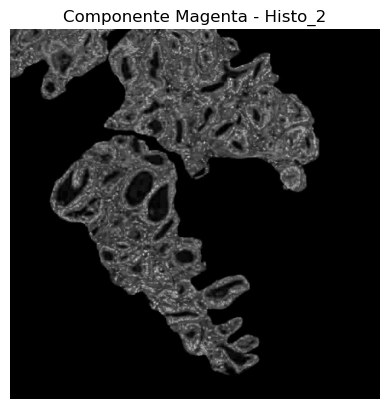

In [2]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta
import numpy as np

# Función para convertir la imagen de RGB a CMYK
def rgb2cmyk(rgb):
    # Extraer los canales RGB
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    
    # Calcular el canal K
    k = 1 - np.max(rgb, axis=2)
    
    # Calcular los canales CMY
    c = (1 - r - k) / (1 - k)
    m = (1 - g - k) / (1 - k)
    y = (1 - b - k) / (1 - k)
    
    return (np.dstack((c, m, y, k)) * 255).astype(np.uint8)

# Convertir la imagen al espacio CMYK
cmyk = rgb2cmyk(image_rgb)

# Visualizar componente Magenta
plt.imshow(cmyk[:, :, 1], cmap="gray")
plt.title("Componente Magenta - Histo_2")
plt.axis("off")
plt.show()



#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

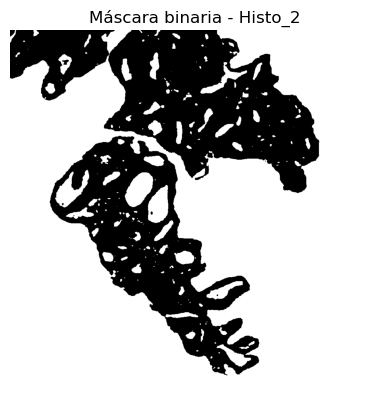

In [3]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante
from skimage.filters import gaussian, threshold_otsu

# Aplicar filtro gaussiano
smoothed = gaussian(cmyk[:, :, 1], sigma=1)

# Calcular umbral de Otsu
threshold = threshold_otsu(smoothed)

# Crear máscara binaria
binary_mask = smoothed < threshold

# Visualizar resultado
plt.imshow(binary_mask, cmap="gray")
plt.title("Máscara binaria - Histo_2")
plt.axis("off")
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

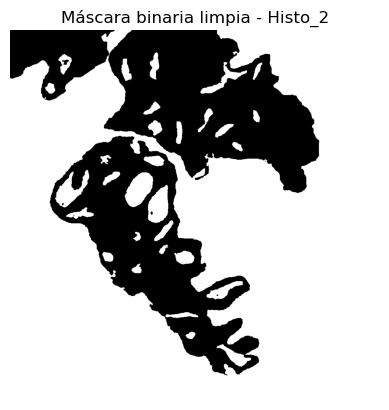

In [4]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
from skimage.morphology import remove_small_objects

# Eliminar objetos pequeños
cleaned_mask = remove_small_objects(binary_mask, min_size=300)

# Visualizar resultado
plt.imshow(cleaned_mask, cmap="gray")
plt.title("Máscara binaria limpia - Histo_2")
plt.axis("off")
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

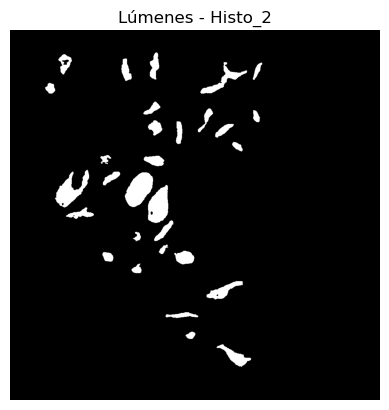

In [5]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 
from skimage.segmentation import flood_fill
import numpy as np
from scipy import ndimage as ndi

# Función para encontrar semillas
def find_seeds(mask):
    # Calcular la transformación de distancia
    distance = ndi.distance_transform_edt(mask)

    # Detectar los dos máximos locales en la transformación de distancia
    local_max = (distance == ndi.maximum_filter(distance, size=3)) & mask
    seed_points = np.argwhere(local_max)
    seed_distances = distance[local_max]
    sorted_seeds = seed_points[np.argsort(seed_distances)[-2:]]  # Seleccionar las dos semillas más alejadas
    
    return sorted_seeds

# Encontrar semillas
sorted_seeds = find_seeds(cleaned_mask)

# Aplicar algoritmo de expansión a partir de semillas
flooded = flood_fill(cleaned_mask, tuple(sorted_seeds[0]), 0)
flooded = flood_fill(flooded, tuple(sorted_seeds[1]), 0)

# Visualizar resultado
plt.imshow(flooded, cmap="gray")
plt.title("Lúmenes - Histo_2")
plt.axis("off")
plt.show()



#### 5) Rellenar los objetos de los lúmenes

/var/folders/dg/zrxcjznn1jj4h_880933fysh0000gp/T/ipykernel_34370/3262190403.py:3: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_fill_holes


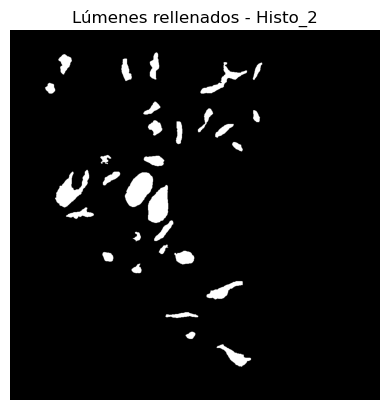

In [6]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
from scipy.ndimage.morphology import binary_fill_holes

# Rellenar lúmenes
filled_lumen = binary_fill_holes(flooded)

# Visualizar resultado
plt.imshow(filled_lumen, cmap="gray")
plt.title("Lúmenes rellenados - Histo_2")
plt.axis("off")
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

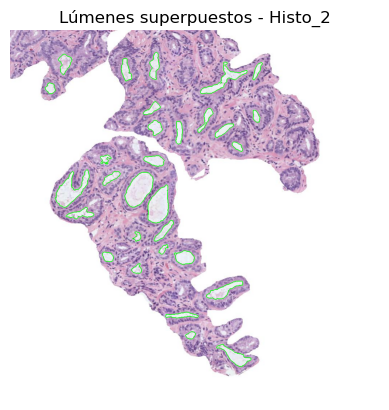

In [7]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta
from skimage.segmentation import mark_boundaries

# Dibujar contornos
contours = mark_boundaries(image_rgb, filled_lumen, color=(0, 1, 0), mode="thick")

# Visualizar resultado
plt.imshow(contours)
plt.title("Lúmenes superpuestos - Histo_2")
plt.axis("off")
plt.show()

#### 7) Identificar y cropear el lumen más grande

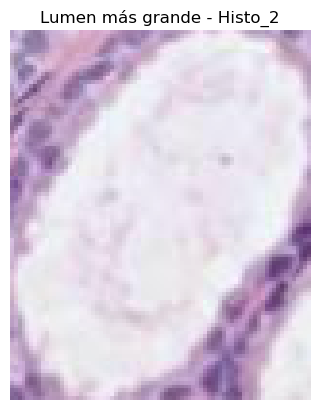

In [8]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.
from skimage.measure import label, regionprops

# Etiquetar regiones
label_image = label(filled_lumen)

# Extraer propiedades de las regiones
regions = regionprops(label_image)

# Encontrar el lumen de mayor área
largest_region = max(regions, key=lambda x: x.area)

# Extraer coordenadas del lumen
min_row, min_col, max_row, max_col = largest_region.bbox

# Recortar imagen
cropped_lumen = image_rgb[min_row:max_row, min_col:max_col]

# Visualizar resultado
plt.imshow(cropped_lumen)
plt.title("Lumen más grande - Histo_2")
plt.axis("off")
plt.show()


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [9]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

# Calcular características
area = largest_region.area
bbox_area = largest_region.bbox_area
convex_area = largest_region.convex_area
eccentricity = largest_region.eccentricity
equivalent_diameter = largest_region.equivalent_diameter
extent = largest_region.extent
feret_diameter = largest_region.feret_diameter_max
major_axis_length = largest_region.major_axis_length
minor_axis_length = largest_region.minor_axis_length
orientation = largest_region.orientation
perimeter = largest_region.perimeter
solidity = largest_region.solidity
compactness = 4 * np.pi * area / perimeter ** 2

# Mostrar resultados
print("Área:", round(area, 4))
print("Área de la bounding box:", round(bbox_area, 4))
print("Área convexa:", round(convex_area, 4))
print("Exentricidad:", round(eccentricity, 4))
print("Diámetro equivalente:", round(equivalent_diameter, 4))
print("Extensión:", round(extent, 4))
print("Diámetro Feret:", round(feret_diameter, 4))
print("Longitud del eje mayor:", round(major_axis_length, 4))
print("Longitud del eje menor:", round(minor_axis_length, 4))
print("Orientación:", round(orientation, 4))
print("Perímetro:", round(perimeter, 4))
print("Solidez:", round(solidity, 4))
print("Compacidad:", round(compactness, 4) )



Área: 4890.0
Área de la bounding box: 7488.0
Área convexa: 5026.0
Exentricidad: 0.8347
Diámetro equivalente: 78.9059
Extensión: 0.653
Diámetro Feret: 106.066
Longitud del eje mayor: 106.5473
Longitud del eje menor: 58.682
Orientación: -0.5615
Perímetro: 280.9777
Solidez: 0.9729
Compacidad: 0.7784
